In [1]:
import numpy as np
import pickle

In [2]:
with open('progress.pickle', 'rb') as f:
    train_progress = pickle.load(f)

In [3]:
print("Max validation accuracy: {:.2f}%".format(np.array(train_progress["val_accuracy"]).max()))

Max validation accuracy: 77.50%


In [4]:
import sys
sys.path.insert( 0, '../..' ) # To be able to access to utils

In [5]:
# ---- Library import ----

import pickle
from time import gmtime, strftime

import albumentations
import math
import torch.nn as nn
from torch.utils.data import DataLoader
import torchy

# ---- My utils ----
from utils.train_arguments import *
from utils.utils_data import *
from utils.utils_training import *

usage: ipykernel_launcher.py [-h] [--verbose] [--epochs EPOCHS]
                             [--batch_size BATCH_SIZE]
                             [--model_name {efficientnet}]
                             [--optimizer {adam,sgd,rmsprop}]
                             [--balanced_sampler]
                             [--depth_coefficient DEPTH_COEFFICIENT]
                             [--width_coefficient WIDTH_COEFFICIENT]
                             [--resolution_coefficient RESOLUTION_COEFFICIENT]
                             [--compound_coefficient COMPOUND_COEFFICIENT]
                             [--learning_rate LEARNING_RATE]
                             [--data_augmentation] [--img_size IMG_SIZE]
                             [--crop_size CROP_SIZE] [--output_dir OUTPUT_DIR]
                             [--path_extension PATH_EXTENSION]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1002/jupyter/kernel-c81f5f7c-55ff-4683-a10b-3c0a095cce94.json


Working with Jupyter notebook! (Default Arguments)
results/new_logs_efficientnet_adam/


In [6]:
# Primero necesitamos reescalar (si usamos los coeficientes de Efficientnet) la resolucion de las imagenes a usar
args.crop_size = math.ceil(args.crop_size * args.resolution_coefficient)
args.img_size = math.ceil(args.img_size * args.resolution_coefficient)


val_aug = albumentations.Compose([
    albumentations.PadIfNeeded(p=1, min_height=args.crop_size, min_width=args.crop_size),
    albumentations.Resize(args.img_size, args.img_size),
    albumentations.CenterCrop(p=1, height=args.crop_size, width=args.crop_size)
])


val_dataset = ISIC2019_FromFolders(data_partition="validation", albumentation=val_aug)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, pin_memory=True, shuffle=False)
print("Data loaded!\n")

Data loaded!



#### Load model

In [7]:
num_classes = len(np.unique(ISIC_TRAIN_DF_TRUTH.target))
print("{} Classes detected!".format(num_classes))
model = model_selector(args.model_name, num_classes, args.depth_coefficient, args.width_coefficient)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model.load_state_dict(torch.load("model_efficientnet_best_accuracy.pt"))

8 Classes detected!


### Making predictions

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
criterion = nn.CrossEntropyLoss()

In [13]:
val_loss, val_correct = [], 0
predicts, predicts_scores, truths = [], [], []
init = -1
model.eval()
with torch.no_grad():
    for image, target in val_loader:
        image, target = image.to(DEVICE), target.to(DEVICE)
        image = image.type(torch.float)
        y_pred = model(image)
        y_pred = torch.sigmoid(y_pred) # Necessary for predicts scores (AUC need values between 0->1)

        loss = criterion(y_pred.float(), target.long())
        val_loss.append(loss.item())
        pred_score, pred = y_pred.max(1)  # get the index of the max log-probability
        val_correct += pred.eq(target).sum().item()

        predicts.append(pred.detach().cpu().numpy())
        predicts_scores.append(pred_score.detach().cpu().numpy())
        truths.append(target.detach().cpu().numpy())

# predicts = np.concatenate(predicts).squeeze(1)
# truths = np.concatenate(truths).squeeze(1)
val_accuracy = 100. * val_correct / len(val_loader.dataset)

In [14]:
predicts = np.concatenate(predicts)
predicts_scores = np.concatenate(predicts_scores)
truths = np.concatenate(truths)

In [15]:
print("Current validation accuracy: {:.2f}%".format(val_accuracy))

Current validation accuracy: 75.03%


In [16]:
print('Current validation Accuracy: {0:.2f}%'.format(accuracy_score(truths, predicts)*100))

Current validation Accuracy: 75.03%


In [17]:
print('Current validation Balanced Accuracy: {0:.2f}%'.format(balanced_accuracy_score(truths, predicts)*100))

Current validation Balanced Accuracy: 58.72%


In [18]:
# Creates a confusion matrix
cm = confusion_matrix(truths, predicts) 

In [19]:
etiquetas_clase = []
for clase in range(0, 8):
    etiquetas_clase.append(CLASS_CATEGORIES[clase])

In [20]:
etiquetas_clase

['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

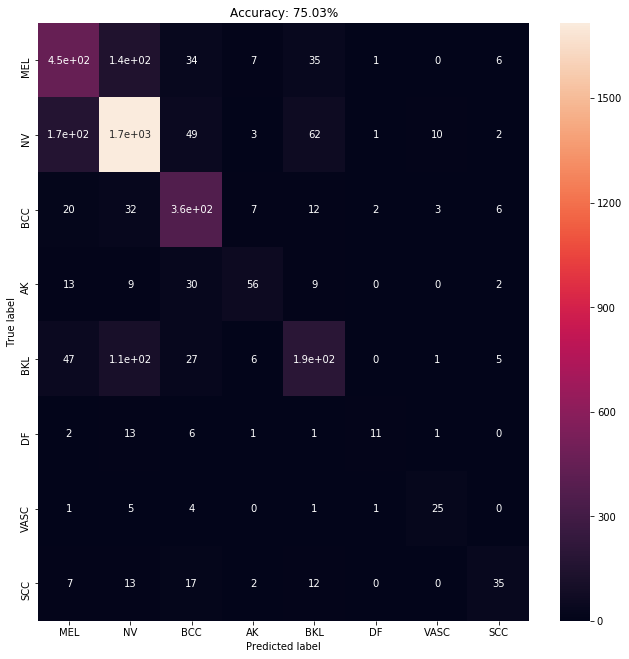

In [22]:
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = etiquetas_clase, 
                     columns = etiquetas_clase)

plt.figure(figsize=(11,11))
sns.heatmap(cm_df, annot=True)
plt.title('Accuracy: {0:.2f}%'.format(accuracy_score(truths, predicts)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [25]:
from sklearn import preprocessing
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [26]:
multiclass_roc_auc_score(truths, predicts)

0.7704215017833098